In [2]:
import Pkg
Pkg.activate(".")

  Activating project at `~`


In [3]:
Pkg.add(["CairoMakie","LinearAlgebra","Distributions","Convex","SCS", "Statistics"])

   Resolving package versions...
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`


In [1]:
using CairoMakie, LinearAlgebra, Statistics, Distributions, Convex, SCS

In [3]:
#Create the data
x = LinRange(-2, 2, 100)
y = x.^2

100-element Vector{Float64}:
 4.0
 3.8400163248648105
 3.683297622691562
 3.5298438934802574
 3.3796551372308943
 3.232731353943475
 3.089072543617999
 2.9486787062544635
 2.8115498418528726
 2.6776859504132227
 2.5470870319355168
 2.4197530864197523
 2.295684113865932
 ⋮
 2.4197530864197523
 2.5470870319355168
 2.6776859504132227
 2.8115498418528726
 2.9486787062544635
 3.089072543617999
 3.232731353943475
 3.3796551372308943
 3.5298438934802574
 3.683297622691562
 3.8400163248648105
 4.0

In [4]:
#Design matrix
col_list = Vector{Float64}[]
for p in 0:19
    push!(col_list, x .^ p)
end
A = reduce(hcat, col_list)

100×20 Matrix{Float64}:
 1.0  -2.0      4.0      -8.0      …  262144.0        -524288.0
 1.0  -1.9596   3.84002  -7.52488          1.81551e5       -3.55766e5
 1.0  -1.91919  3.6833   -7.06896          1.24776e5       -2.39469e5
 1.0  -1.87879  3.52984  -6.63183      85074.5        -159837.0
 1.0  -1.83838  3.37966  -6.2131       57524.3             -1.05752e5
 1.0  -1.79798  3.23273  -5.81239  …   38559.1         -69328.4
 1.0  -1.75758  3.08907  -5.42928      25612.6         -45016.0
 1.0  -1.71717  2.94868  -5.06339      16851.8         -28937.5
 1.0  -1.67677  2.81155  -4.71432      10977.7         -18407.1
 1.0  -1.63636  2.67769  -4.38167       7076.8         -11580.2
 1.0  -1.59596  2.54709  -4.06505  …    4512.26         -7201.38
 1.0  -1.55556  2.41975  -3.76406       2844.06         -4424.1
 1.0  -1.51515  2.29568  -3.47831       1770.96         -2683.28
 ⋮                                 ⋱                  
 1.0   1.55556  2.41975   3.76406       2844.06          4424.1
 1.0 

In [5]:
#Function to perform least squares
function fitlq(A, y)
    Ainv = pinv(A)
    return Ainv * y
end

fitlq (generic function with 1 method)

In [6]:
#Function to perform Lasso
function lasso(A, y, λ1, λ2)
    x = Variable(size(A)[2])
    problem = minimize(norm(A * x - y, 2) + λ1 * norm(x, 1) + λ2 * norm(x, 2))
    solve!(problem, SCS.Optimizer; silent = true)
    return vec(evaluate(x))
end

lasso (generic function with 1 method)

In [7]:
coeffs_ls = zeros(20, 100)      #Least Squares 
coeffs_lasso = zeros(20, 100)   #LASSO 

#for errors 
errors_ls = zeros(100)
errors_lasso = zeros(100)

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [8]:
#Run 100 trials 
for i in 1:100
    y_noise = x.^2 .+ 0.1 * randn(100)
    coeffs_ls[:, i] = fitlq(A, y_noise)
    coeffs_lasso[:, i] = lasso(A, y_noise, 0.1, 0.01) 
end

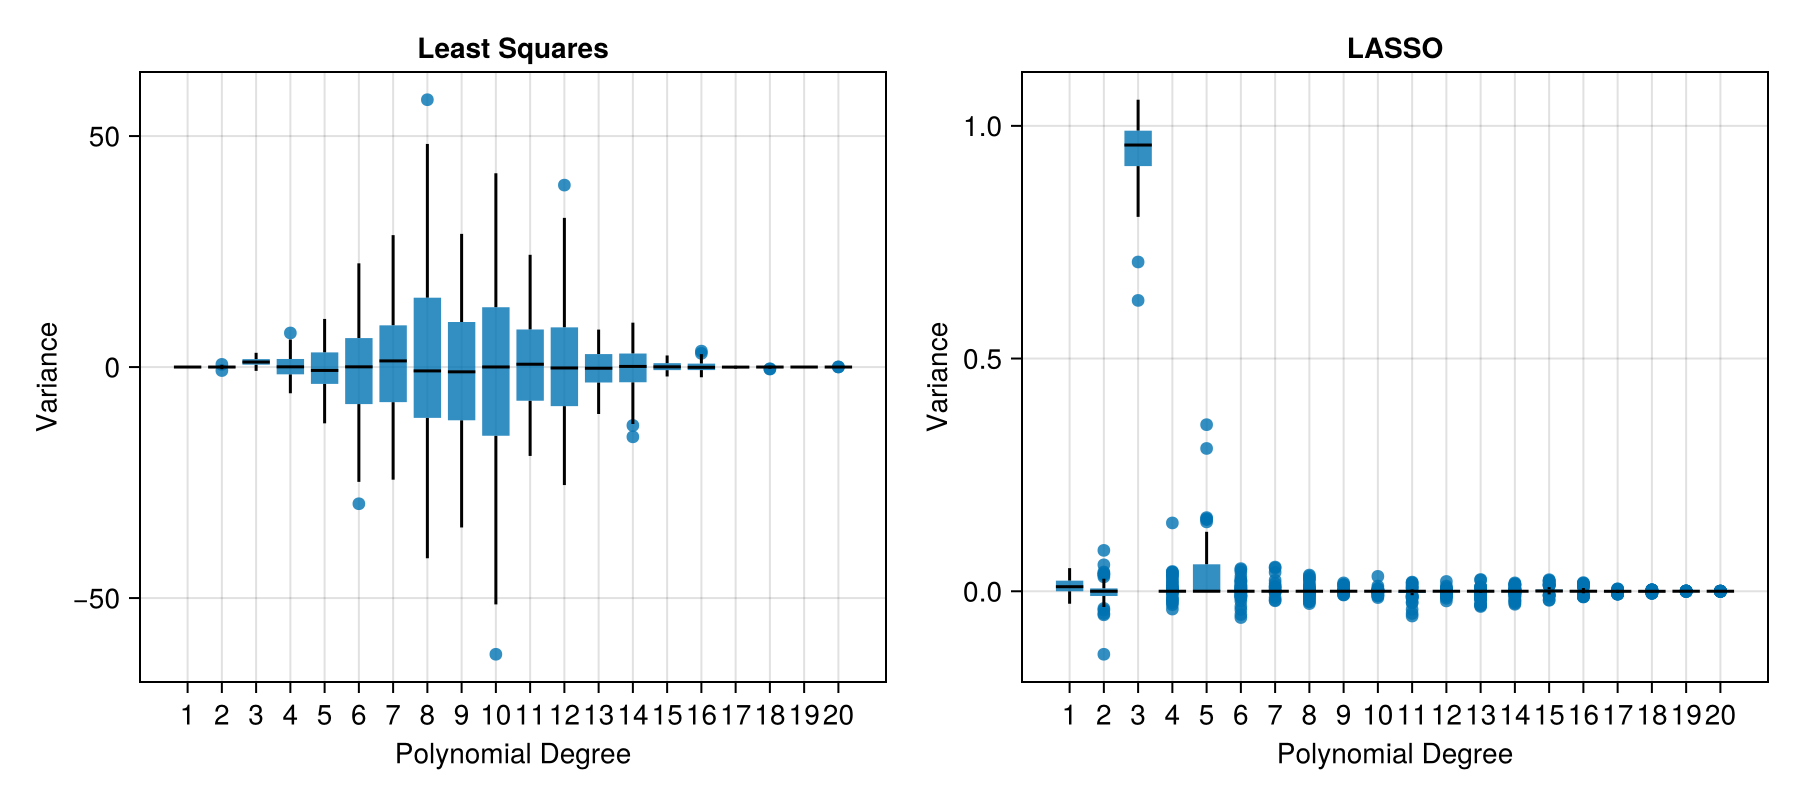

In [9]:
#Create boxplot 
fig = Figure(size = (900, 400))

#Least Squares
ax1 = Axis(fig[1, 1], title = "Least Squares", xlabel = "Polynomial Degree", ylabel = "Variance", xticks = 1:20)
boxplot!(ax1, repeat(1:20, 100), vec(coeffs_ls))

#LASSO
ax2 = Axis(fig[1, 2], title = "LASSO", xlabel = "Polynomial Degree", ylabel = "Variance", xticks = 1:20)
boxplot!(ax2, repeat(1:20, 100), vec(coeffs_lasso))

fig

In [24]:
#calculate errors for Least Squares and LASSO
errors_ls = [norm(y - A * coeffs_ls[:, i]) for i in 1:100]  # Least Squares errors
errors_lasso = [norm(y - A * coeffs_lasso[:, i]) for i in 1:100]  # LASSO errors

100-element Vector{Float64}:
 0.3114373285951176
 0.41391607250465573
 0.26723182048807387
 0.37366002558865324
 0.32041041886174093
 0.2919558127190882
 0.37357695889886583
 0.4186304374288999
 0.26060738264074595
 0.30644221671449834
 0.2528777081712547
 0.31620823345109283
 0.2722321078846306
 ⋮
 0.30822024324270353
 0.35654675886188303
 0.22708591343495785
 0.3253694140214333
 0.4182517246877683
 0.32376453466348804
 0.32599330008043853
 0.1956568373596119
 0.3612553904927642
 0.2814257761943404
 0.34813317430415036
 0.35088332365705477

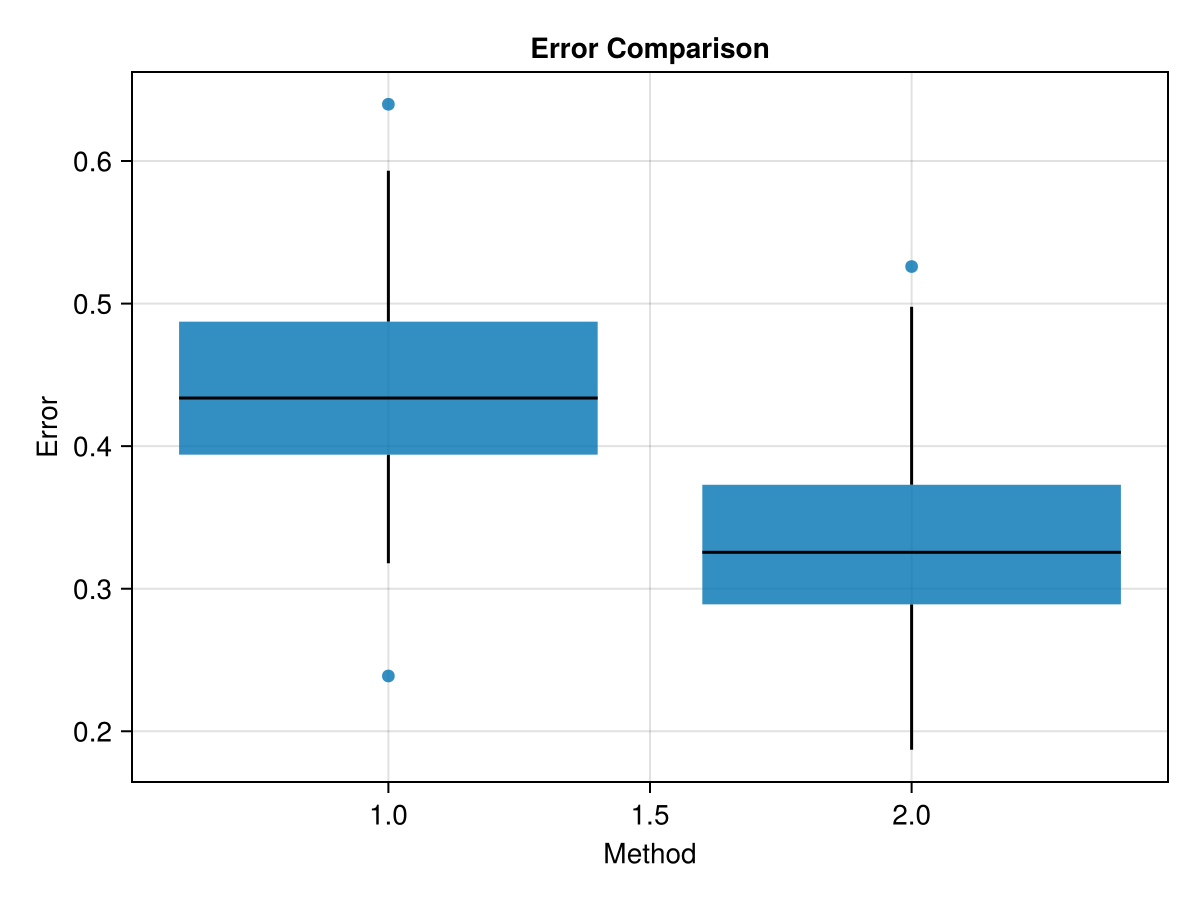

In [34]:
combined_errors = vcat(errors_ls, errors_lasso)
group = repeat([1,2], inner=100)

#error comparison between Least Squares and LASSO
fig=Figure()
ax1 = Axis(fig[1, 1], title = "Error Comparison", xlabel = "Method", ylabel = "Error")
boxplot!(ax1, group, combined_errors)

fig